# Machine Learning Project: Predicting a film’s gross revenue

In [137]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_selection import  mutual_info_regression, SelectKBest
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

from pandas.plotting import scatter_matrix
import seaborn as sns


In [118]:
# loading the data

X1 = pd.read_csv("X1.csv" )
Y1 = pd.read_csv("Y1.csv" , header=None , names =["revenue"])

### Preprocessing of data

In [ ]:
def DataPreProcessing(dataframe):

    dataframe.insert(10, "genre3", "")
    dataframe.insert(10, "genre2", "")
    dataframe.insert(10, "genre1", "")

    genre_individual(dataframe)
    
    toDrop = ["Unnamed: 0", "title", "img_url", "description", "genres", "is_adult"]
    for col in toDrop :
        dataframe=dataframe.drop(col,axis=1)

    dataframe = fillRuntime(dataframe)  # fill empty runtime with NaN values
    dataframe = weightedGenres(dataframe) # weighted on-hot encoding of genres
    dataframe = oneHotStudio(dataframe)
    dataframe = processEmbeddings(dataframe)
    return dataframe
    #    directorAndActors(dataframe)

def fillRuntime(dataframe):

    averageTimeByGenre = {}
    for i in range (len (dataframe["genre1"].unique())):
        averageTimeByGenre[dataframe["genre1"].unique()[i]] = 0
    
    for i in range (len (dataframe["runtime"])):
        if (dataframe["runtime"][i] != '\\N'):
            averageTimeByGenre[dataframe["genre1"][i]]+= int(dataframe["runtime"][i])            
            
    for i in range (len (dataframe["genre1"].unique())):
        averageTimeByGenre[dataframe["genre1"].unique()[i]] /= dataframe["genre1"].value_counts()[dataframe["genre1"].unique()[i]]     

    for i in range (len (dataframe["genre1"])):
        if dataframe["runtime"][i] == '\\N':
            dataframe["runtime"][i] = int(averageTimeByGenre[dataframe["genre1"][i]])
        else: 
            dataframe["runtime"][i] = int(dataframe["runtime"][i])
    return dataframe

def weightedGenres(dataframe):

    ListOfGenre = list(set(list(dataframe["genre1"].unique()) + list(dataframe["genre2"].unique()) + list(dataframe["genre3"].unique())))
    ListOfGenre.remove("")
    ListOfGenre.remove('\\N')
    
    for i in range (len(ListOfGenre)):
        dataframe[ListOfGenre[i]] = 0

    for i in range (len(dataframe["genre1"])):
        if dataframe["genre1"][i] != "\\N":
            dataframe[dataframe["genre1"][i]][i] = 3
            
    for i in range (len(dataframe["genre2"])):
        if dataframe["genre2"][i] != "\\N" and dataframe["genre2"][i] != "":
            dataframe[dataframe["genre2"][i]][i] = 2
            
    for i in range (len(dataframe["genre3"])):
        if dataframe["genre3"][i] != "\\N" and dataframe["genre3"][i] != "":
            dataframe[dataframe["genre3"][i]][i] = 1
            
    dataframe=dataframe.drop("genre1",axis=1)
    dataframe=dataframe.drop("genre2",axis=1)
    dataframe=dataframe.drop("genre3",axis=1)
    return dataframe

def oneHotStudio(dataframe):

    # Count the number of occurrences of each category
    counts = dataframe["studio"].value_counts()

    # Sort the categories by their frequency in descending order
    counts = counts.sort_values(ascending=False)
    k = 9
    # Select the k most represented categories
    top_10 = counts[:k].index

    # Apply binary encoding to the selected categories
    dataframe = pd.get_dummies(dataframe, columns=['studio'], prefix='std', prefix_sep='_', dummy_na=False)
    for col in dataframe.columns:
        if col[0:3] == "std":
            if(col[4:] not in top_10):
                dataframe.drop(col, axis=1, inplace=True)

    return dataframe

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def genre_individual(dataset):
    for i in range (len(dataset["genres"])):
        genres_here = dataset["genres"][i].split(",")
        for j in range(len(genres_here)):
            name = "genre"+str(j+1)
            dataset.loc[i, name]=genres_here[j]

def processEmbeddings(dataframe):

    for i in range (len(dataframe)):
        LaList = dataframe['text_embeddings'][i][1:][:-1].split(',')
        dataframe['text_embeddings'][i] = [float(item) for item in LaList] 

    for i in range (len(dataframe)):
        LaList = dataframe['img_embeddings'][i][1:][:-1].split(',')
        dataframe['img_embeddings'][i] = [float(item) for item in LaList] 

    return dataframe

def directorAndActors(dataset):
    actorsList = []
    directorList = []
    for i in range (len(dataset["description"])):
        print("\r"+str(i), end= "")
        step1= remove_prefix(dataset["description"][i], dataset["title"][i] + ": ")
        step2= step1.split('. ')
        if ("Directed " in step2[0]):
            step3= remove_prefix(step2[0], "Directed by ")
            if (step3 not in directorList):
                directorList.append(step3)
                dataset[step3] = 0
            dataset.at[i, step3] = 1
            
        elif ("With" in step2[0]):
            step4= remove_prefix(step2[0], "With ").split(', ')
        if (len(step2) >=2):
            if ("With" in step2[1]):
                step4= remove_prefix(step2[1], "With ").split(', ')
            
        
        for j in range (len(step4)):
            if step4[j] not in actorsList:
                actorsList.append(step4[j])
                dataset[step4[j]] = 0
                dataset.at[i, step4[j]] = 1
            else :
                dataset.at[i, step4[j]] = 1
    return actorsList

def color_Dico():
    genres = set()

    for i in range (len(X1["genres"])):
        for j in range (len(X1["genres"][i].split(","))):
            genres.add(X1["genres"][i].split(",")[j])
    
    rgb_values = sns.color_palette("Set2", 27)
    dico = {}
    for i in range (len(genres)):
        dico[genres.pop()]=rgb_values[i]
    return dico

X1 = DataPreProcessing(X1)



In [ ]:
X1.head()

### Dimensionnality reduction of embeddings

In [121]:
def ToNpArray(pdSeries):
    
    list = pdSeries.tolist()
    npArray = np.array(list) 
    return npArray


data = ToNpArray(X1['text_embeddings'])
data = StandardScaler().fit_transform(data)  # scaling the data

def compute_embeddings():
    textembed3 =  TSNE(n_components=3, random_state=42, method='exact').fit_transform(data)
    np.save('embed/text3.npy', textembed3)

    data = ToNpArray(X1['img_embeddings'])
    data = StandardScaler().fit_transform(data)  # scaling the data
    imgembed3 =  TSNE(n_components=3, random_state=42, method='exact').fit_transform(data)
    np.save('embed/imgembed3.npy', imgembed3)
    imgembed6 =  TSNE(n_components=6, random_state=42, method='exact').fit_transform(data)
    np.save('embed/imgembed6.npy', imgembed6)


In [122]:


textembed = np.load("embed/text3.npy")
X1.drop("text_embeddings", axis=1, inplace=True)
for i in range(3):
    X1["text_embeddings%d"%(i)] = textembed[:,i]


imgembed = np.load("embed/imgembed3.npy")
X1.drop("img_embeddings", axis=1, inplace= True)
for i in range(3):
    X1["img_embeddings%d"%(i)] = imgembed[:,i]


scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1.to_numpy())
X1= pd.DataFrame(X1_scaled, columns=X1.columns)

X1.to_csv("processedData/st9im3txt3")

### Feature selection & extraction

In [168]:
X1 = pd.read_csv("processedData/st9im3txt3")
Y1 = pd.read_csv("Y1.csv", header=None , names =["revenue"])

X1.head()


,Unnamed: 0,ratings,n_votes,production_year,runtime,release_year,Short,Music,News,Fantasy,...,std_Par.,std_Sony,std_Uni.,std_WB,text_embeddings0,text_embeddings1,text_embeddings2,img_embeddings0,img_embeddings1,img_embeddings2
0,0,0.062975,0.809200,1.111354,0.430581,0.933839,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,-0.456871,0.145407,0.444517,-0.769388,-0.558291,1.482851
1,1,1.263828,-0.271776,-0.073389,-0.252887,1.366959,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,-0.931708,-0.756918,1.154724,0.072343,-1.202546,-1.876219
2,2,-0.451677,-0.256258,-1.596629,1.114049,-2.531122,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.334171,1.056132,-0.831411,1.581208,0.102715,0.564466
3,3,0.148750,-0.215474,-0.242638,0.430581,-0.798642,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.826204,-0.160741,0.399846,-0.729842,-0.143565,-1.128653
4,4,-1.995631,-0.265518,-1.258132,0.523781,-2.098002,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.073563,-1.166933,0.823457,1.462627,-0.783300,0.206789


(3540, 47)
[9.99955975e-01 2.11905867e-06 2.01039742e-06 1.93008956e-06
 1.77176453e-06 1.62340867e-06 1.47157213e-06 1.26534332e-06
 1.23160710e-06 1.18665725e-06 1.12648140e-06 1.11826943e-06
 1.08678919e-06 1.06319142e-06 1.05937866e-06 1.03511544e-06
 1.02219955e-06 1.00500013e-06 9.97894695e-07 9.72382620e-07
 9.56862565e-07 9.44353245e-07 9.35584388e-07 9.29033764e-07
 9.15492369e-07 9.09384353e-07 8.99103185e-07 8.69515345e-07
 8.55989669e-07 8.43287714e-07 8.34302266e-07 8.08889362e-07
 7.96043106e-07 7.67910294e-07 7.24882170e-07 7.20388994e-07
 6.91258867e-07 6.46785747e-07 6.33980609e-07 5.97060329e-07
 5.60337919e-07 5.43602702e-07 4.63548179e-07 4.18755882e-07
 3.00763601e-07 2.80291372e-07 8.12708496e-08]


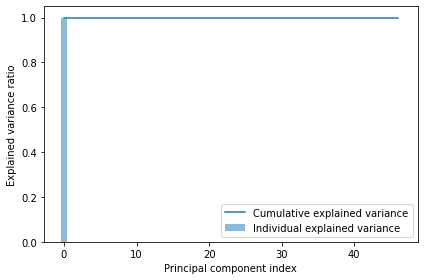

In [172]:
### we first do a PCA analysis

pca = PCA()

X1 = pca.fit_transform(X1)
print(X1.shape)
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca)

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Filter methods

In [152]:

# 1 : feature selection using min redundancy max relevance approach

# Compute the Pearson correlation between each feature and the target variable

def minRedMaxRel(X1, Y1, k):

    available = list(X1.columns)
    selected = []
    corrThreshold = 0.6
    for i in range(k):

        if(len(available) == 0):
            break
        mi = np.argsort(mutual_info_regression(X1[available].to_numpy(), Y1.to_numpy().ravel()))
        best = available[mi[-1]]
        selected.append(best)
        for av in available:     
            corrcoeff, _ = pearsonr(X1[av].to_numpy(), X1[best].to_numpy())
            if corrcoeff > corrThreshold:
                available.remove(av)

    return X1[selected], selected

    
X_selected, selected  = minRedMaxRel(X1, Y1, 15)


In [158]:
X1.head()


,Unnamed: 0,ratings,n_votes,production_year,runtime,release_year,Short,Music,News,Fantasy,...,std_Par.,std_Sony,std_Uni.,std_WB,text_embeddings0,text_embeddings1,text_embeddings2,img_embeddings0,img_embeddings1,img_embeddings2
0,0,0.062975,0.809200,1.111354,0.430581,0.933839,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,-0.456871,0.145407,0.444517,-0.769388,-0.558291,1.482851
1,1,1.263828,-0.271776,-0.073389,-0.252887,1.366959,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,-0.931708,-0.756918,1.154724,0.072343,-1.202546,-1.876219
2,2,-0.451677,-0.256258,-1.596629,1.114049,-2.531122,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.334171,1.056132,-0.831411,1.581208,0.102715,0.564466
3,3,0.148750,-0.215474,-0.242638,0.430581,-0.798642,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.826204,-0.160741,0.399846,-0.729842,-0.143565,-1.128653
4,4,-1.995631,-0.265518,-1.258132,0.523781,-2.098002,-0.136678,-0.194455,-0.023776,-0.219846,...,-0.193687,-0.173113,-0.211083,-0.234152,0.073563,-1.166933,0.823457,1.462627,-0.783300,0.206789


In [164]:
# feature extraction, we first project and then extract based on mutual information
embeddings = [PCA, TSNE, Isomap, MDS]
def feature_extraction(X1, Y1, d, k, embed):

    """ performs dimensionnality reduction on the whole dataset before extracting most relevant features with respect to target variable
        d : dimension after dimensionnality reduction
        k : number of features extracted
    """
    X1 = embed(n_components=d).fit_transform(X1)  
    mi = np.argsort(mutual_info_regression(X1, Y1.to_numpy().ravel()))
    extracted = np.array([X1[:, mi[-1]]])
    for i in range(2, k+1):
        extracted = np.concatenate((extracted, np.array([X1[:, mi[-i]]])), axis=0)

    return extracted.T

extracted = feature_extraction(X1, Y1, 10, PCA)



(1, 3540)
(3540,)
(2, 3540)
(3540,)
(3, 3540)
(3540,)
(4, 3540)
(3540,)
(5, 3540)
(3540,)
(6, 3540)
(3540,)
(7, 3540)
(3540,)
(8, 3540)
(3540,)
(9, 3540)
(3540,)


In [153]:
print(selected)

['n_votes', 'release_year', 'production_year', 'runtime', 'ratings', 'Drama', 'text_embeddings2', 'text_embeddings1', 'text_embeddings0', 'Comedy', 'Adventure', 'Documentary', 'std_Uni.', 'Action', 'Crime']


In [132]:

# Create some sample data
columns = ["ratings"]
vector_values = X1[columns].to_numpy()
scalar_values = Y1.to_numpy()
print(vector_values.shape)
print(scalar_values.shape)

# Compute the mutual information

mutual_info = mutual_info_score(vector_values[0], scalar_values[0])

print(mutual_info)  # Outputs: 0.31127812445913283

(3540, 1)
(3540, 1)
0.0


c:\Users\louis\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [ ]:
X2 = pd.read_csv("X2.csv" )
X2 = DataPreProcessing(X1)

In [ ]:
print(testSet.columns.values.tolist())
allColumns = list(set(testSet.columns.values.tolist() + Ready.columns.values.tolist()))
print(allColumns)

for i in range(len (allColumns)):
    if (allColumns[i] not in testSet.columns.values.tolist()):
        testSet[allColumns[i]]=0
    if (allColumns[i] not in Ready.columns.values.tolist()):
        Ready[allColumns[i]]=0

testSet = testSet.reindex(sorted(testSet.columns), axis=1)
Ready = Ready.reindex(sorted(Ready.columns), axis=1)

In [12]:
from sklearn.linear_model import LinearRegression
revenue = Y1.pop("revenue")
reg = LinearRegression().fit(Ready, revenue)

In [13]:
Y1 = pd.read_csv("Y1.csv" , header=None , names =["revenue"])
reg.score(Ready, revenue)

1.0

In [14]:
prediction = reg.predict(testSet)


In [19]:
np.savetxt("foo.csv", prediction, delimiter=",")